### Analysis on MK data tar file collected using mk_run_ex.sh file

- preparation

In [1]:
pwd

u'/Users/yj/repo/mk/ipynb/analysis'

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# import os, glob, subprocess, tarfile, dill, shutil,MP
# import MP.lib.temp
# import lib
import lib,glob
import MP.lib.mpl_lib
reload(lib)

<module 'lib' from 'lib.pyc'>

In [4]:
lib.syncArchiveFromPal()

#!/bin/bash
    cd ~/repo/mk/archive
    bash rsyncFromPal.sh
    cd -


In [18]:
!tree  ../../ -d |head -n 10
!echo  '\n********************************\nFind recently added tar files from Palmetto\n********************************\n'
!ls -lstr ../../archive/MKVPSCHARD*.tar |tail -n 15

../../
|-- archive
|   |-- MKVARHARD_0.990_20160810-0606-4beb26-
|   |   |-- mk_0.0100_H48R_Voce_U_0.990_-796b34-
|   |   |-- mk_0.0100_Yld1_Voce_U_0.990_-a118fe-
|   |   |-- mk_0.1500_H48R_Voce_U_0.990_-7393a4-
|   |   `-- mk_0.1500_Yld2_Voce_U_0.990_-74abca-
|   `-- MKVARHARD_0.998_20160810-0231-e0006a-
|       |-- mk_0.0100_H48R_Voce_U_0.998_-e6ce99-
|       |-- mk_0.0100_H48R_Voce_U_0.998_-e6ce99-\ 2

********************************
Find recently added tar files from Palmetto
********************************

 2240 -rw-r--r--  1 yj  admin  1146880 Aug  8 12:03 ../../archive/MKVPSCHARD_0.992_20160808-1203-458f3b-.tar
 2240 -rw-r--r--  1 yj  admin  1146880 Aug  8 12:03 ../../archive/MKVPSCHARD_0.990_20160808-1203-467f2f-.tar
 2240 -rw-r--r--  1 yj  admin  1146880 Aug  8 12:04 ../../archive/MKVPSCHARD_0.994_20160808-1204-d93c0a-.tar
 2240 -rw-r--r--  1 yj  admin  1146880 Aug  8 12:09 ../../archive/MKVPSCHARD_0.985_20160808-1209-a80a6a-.tar
 2240 -rw-r--r--  1 yj  admin  1146880 Aug  

In [19]:
!ls -lstr ../../archive/MKVARHARD*.tar |tail -n 15

 1704 -rw-r--r--  1 yj  admin   870400 Aug  8 17:49 ../../archive/MKVARHARD_0.996_20160808-1749-1c05b3-.tar
 1704 -rw-r--r--  1 yj  admin   870400 Aug  8 17:49 ../../archive/MKVARHARD_0.994_20160808-1749-9fec8e-.tar
 1704 -rw-r--r--  1 yj  admin   870400 Aug  8 17:54 ../../archive/MKVARHARD_0.992_20160808-1753-420a16-.tar
 9144 -rw-r--r--  1 yj  admin  4679680 Aug  9 07:11 ../../archive/MKVARHARD_0.998_20160809-0711-d6e0bf-.tar
 9464 -rw-r--r--  1 yj  admin  4843520 Aug  9 09:00 ../../archive/MKVARHARD_0.996_20160809-0900-d424bf-.tar
 9584 -rw-r--r--  1 yj  admin  4904960 Aug  9 09:49 ../../archive/MKVARHARD_0.994_20160809-0949-24c3aa-.tar
 9864 -rw-r--r--  1 yj  admin  5048320 Aug  9 10:38 ../../archive/MKVARHARD_0.992_20160809-1038-1fa8bf-.tar
10064 -rw-r--r--  1 yj  admin  5150720 Aug  9 10:59 ../../archive/MKVARHARD_0.990_20160809-1059-2adc81-.tar
10240 -rw-r--r--  1 yj  admin  5242880 Aug  9 11:48 ../../archive/MKVARHARD_0.985_20160809-1148-4f64b5-.tar
10504 -rw-r--r--  1 yj  admi

In [32]:
## VPSC 
# fns_master=glob.glob('MKVPSCHARD_*_20160806*.tar')
## MK
# fns_master=glob.glob('mk_*_20160730*.tar')
## VPSC-MK - 20160808
# fns_master = ['MKVPSCHARD_0.996_20160808-0115-1ff82a-.tar']
# fns_master = glob.glob('MKVPSCHARD_0.9??_20160808-12*.tar')

fns_master = glob.glob('../../archive/MKVPSCHARD_0.9??_20160808-15*.tar') ## VPSC hardening (path-dependent hardening)
#fns_master = glob.glob('../../archive/MKVARHARD_0.9??_20160810-*.tar')      ## ISOTROPIC hardening

fns_master.sort()
for i in xrange(len(fns_master)):
    print fns_master[i]

../../archive/MKVPSCHARD_0.994_20160808-1526-2e4376-.tar
../../archive/MKVPSCHARD_0.996_20160808-1536-0674d8-.tar
../../archive/MKVPSCHARD_0.998_20160808-1526-500966-.tar


In [33]:
# %%timeit
%time
myMaster=lib.master(fns_master)

CPU times: user 8 µs, sys: 4 µs, total: 12 µs
Wall time: 24.1 µs


- Example for individual plotting

fld file name: minFLD-e6d105.txt
fld file name: minFLD-ba0832.txt
fld file name: minFLD-09b181.txt


[<lib.member instance at 0x1081d5b00>,
 <lib.member instance at 0x107bc9440>,
 <lib.member instance at 0x1072088c0>]

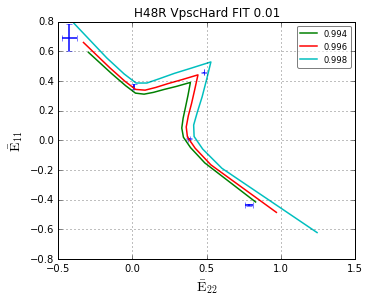

In [34]:
myMaster.compareFit_ind(iyf=0,ihf=0,ipath=0,ieps=0,iplot=True)

- Plotting everything.

In [35]:
%%time
myMaster.plot_all()

masterMKdata.pdf has been saved
CPU times: user 7.12 s, sys: 148 ms, total: 7.26 s
Wall time: 7.32 s


In [36]:
d=myMaster.eachMKs[0]

In [38]:
!open masterMKdata.pdf